In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib import rcParams
from ForceMapping import forceMapping as fm
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)

#### load the data

In [3]:
period = 140

In [4]:
data_with_ad = np.loadtxt('data_for_train.csv', delimiter=',')
data_loss_ad = np.load('RF_limb.npy')

In [5]:
data_for_train = np.vstack((data_with_ad, data_loss_ad))
scaler = MinMaxScaler(feature_range=(-1, 1))
data_for_train[:,16:20] = scaler.fit_transform(data_for_train[:,16:20].reshape(-1,1)).reshape(-1,4)

### Prepare the train, val, test data

In [62]:
def generate_split(start, end):
    # Generate the ID list from start to end (inclusive)
    ids = np.arange(start, end + 1)
    
    # Shuffle the ID list randomly
    np.random.shuffle(ids)
    
    # Calculate the split sizes
    total_size = len(ids)
    train_size = int(0.75 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size  # Remainder goes to the test set
    
    # Split the IDs
    train_set = ids[:train_size]
    val_set = ids[train_size:train_size + val_size]
    test_set = ids[train_size + val_size:]
    
    return train_set, val_set, test_set

# Example usage
train_ad, val_ad, test_ad = generate_split(0, 50)
train_lose, val_lose, test_lose = generate_split(51, 80)

train_id =  np.concatenate((train_ad,train_lose))
val_id = np.concatenate((val_ad,val_lose))
test_id = np.concatenate((test_ad,test_lose))

np.random.shuffle(train_id)
np.random.shuffle(val_id)
np.random.shuffle(test_id)



In [63]:
train_set, val_set, test_set = generate_data_sets(train_id, val_id, test_id, data_for_train)

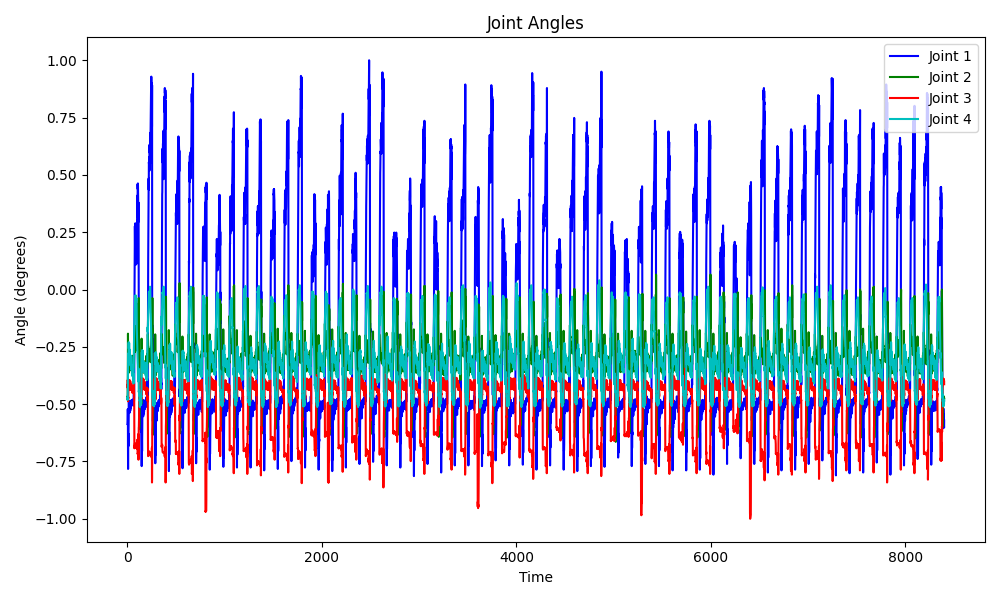

In [66]:
plt.close('all')
plot_joint_angles(train_set[:,16:20])

In [72]:
esn_optimal = ESN(4, 100, 2, 0.95,  0.2)
esn_optimal.fit(train_set[:,16:20], train_set[:,32:34])


In [73]:
grf_predicted = esn_optimal.predict(test_set[:,16:20])

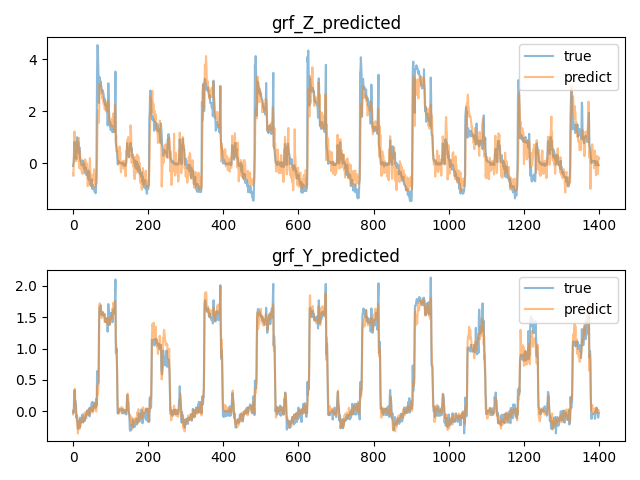

In [74]:
plt.close('all')
plt.subplot(2,1,1)
plt.plot(test_set[:,32], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,0], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Z_predicted')

plt.subplot(2,1,2)
plt.plot(test_set[:,33], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,1], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Y_predicted')
plt.tight_layout()

In [67]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, 
                 spectral_radius=0.95, sparsity=0.1, leak_rate=0.9, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.leak_rate = leak_rate

        # Input weights
        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_size))

        # Reservoir weights
        W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(*W.shape) < sparsity
        W *= mask  # sparsify
        eigvals = np.max(np.abs(np.linalg.eigvals(W)))
        self.Wres = W * (spectral_radius / eigvals)

        # Output weights (trained later)
        self.Wout = None

        self.state = np.zeros((reservoir_size,))

    def _update_state(self, u):
        pre_activation = np.dot(self.Win, u) + np.dot(self.Wres, self.state)
        new_state = np.tanh(pre_activation)
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * new_state
        return self.state

    def fit(self, inputs, targets, washout=50, ridge_lambda=1e-6):
        states = []
        for u in inputs:
            state = self._update_state(u)
            states.append(state)

        states = np.array(states)
        states_washed = states[washout:]
        targets_washed = targets[washout:]

        # Add bias term
        extended_states = np.hstack([states_washed, np.ones((states_washed.shape[0], 1))])
        
        # Ridge regression
        self.Wout = np.dot(np.linalg.pinv(extended_states), targets_washed)

    def predict(self, inputs):
        outputs = []
        for u in inputs:
            state = self._update_state(u)
            extended_state = np.concatenate([state, [1]])  # Add bias
            y = np.dot(extended_state, self.Wout)
            outputs.append(y)
        return np.array(outputs)

In [53]:
def generate_data_sets(train_id, val_id, test_id, data_for_train, period=140):
    # Initialize empty lists to hold the subsets
    train_set = []
    val_set = []
    test_set = []

    # Populate train_set
    for i in train_id:
        train_set.append(data_for_train[period * i: period * (i + 1), :])

    # Populate val_set
    for i in val_id:
        val_set.append(data_for_train[period * i: period * (i + 1), :])

    # Populate test_set
    for i in test_id:
        test_set.append(data_for_train[period * i: period * (i + 1), :])

    return np.vstack(train_set), np.vstack(val_set), np.vstack(test_set)

In [2]:
def plot_joint_angles(joint_angles, title="Joint Angles", xlabel="Time", ylabel="Angle (degrees)"):
    """
    绘制四关节角度信号
    
    参数:
        joint_angles: 形状为(n,4)的numpy数组，包含四个关节的角度数据
        title: 图表标题 (默认: "Joint Angles")
        xlabel: x轴标签 (默认: "Time")
        ylabel: y轴标签 (默认: "Angle (degrees)")
    """
    # 检查输入数据
    if not isinstance(joint_angles, np.ndarray) or joint_angles.shape[1] != 4:
        raise ValueError("输入数据必须是形状为(n,4)的numpy数组")
    
    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 时间轴 (假设是等间隔采样)
    time = np.arange(joint_angles.shape[0])
    
    # 为每个关节绘制曲线
    joints = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4']
    colors = ['b', 'g', 'r', 'c']  # 不同颜色区分关节
    
    for i in range(4):
        ax.plot(time, joint_angles[:, i], 
                color=colors[i], 
                label=joints[i],
                linewidth=1.5)
    
    # 添加图例和标签
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # # 添加网格
    # ax.grid(True, linestyle='--', alpha=0.6)
    
    # 自动调整布局
    plt.tight_layout()
    
    # 显示图形